<a href="https://colab.research.google.com/github/Exper626/Air-Quality-DE/blob/main/VOC_AQI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Possible necessary imports

In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=bc0e628bde7120a5f234471f2987e6b9b83826e6f6ee793ebfe95d6c25631896
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [3]:
from pyspark.sql.window import Window

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

start a spark session

In [5]:
spark = SparkSession.builder.appName("Formaldehyde").getOrCreate()

load the data

In [6]:
cmb_nuw_mat = spark.read.csv("/content/col_mat_nuw_output.csv", inferSchema=True)
kandy = spark.read.csv("/content/kan_output.csv", inferSchema=True)
jaf_kur_mon = spark.read.csv("/content/mon_kur_jaf_output.csv", inferSchema=True)

# Exploratory data analysis and Data Pre-processing

In [7]:
data_frames = [("Colombo, Deniyaya, Matara, Nuwara Eliya", cmb_nuw_mat), ("Kandy", kandy), ("Bibile, Monaragala, Kurunegala, Jaffna", jaf_kur_mon)]

first rows of the dataframe

In [8]:
for name, df in data_frames:
    print("City:", name)
    df.show()

City: Colombo, Deniyaya, Matara, Nuwara Eliya
+--------------------+--------------+----------+----------+
|                 _c0|           _c1|       _c2|       _c3|
+--------------------+--------------+----------+----------+
|1.969834395781014...|Colombo Proper|2019-01-01|2019-01-02|
|2.625522171968594...|Colombo Proper|2019-01-02|2019-01-03|
|9.852118897938794E-5|Colombo Proper|2019-01-03|2019-01-04|
|2.099320518114242E-4|Colombo Proper|2019-01-04|2019-01-05|
|1.785337298892930...|Colombo Proper|2019-01-05|2019-01-06|
|1.082296700235670...|Colombo Proper|2019-01-06|2019-01-07|
|3.926829280477309...|Colombo Proper|2019-01-07|2019-01-08|
|9.153156350685351E-5|Colombo Proper|2019-01-08|2019-01-09|
|1.205978992853015...|Colombo Proper|2019-01-09|2019-01-10|
|1.297723562983258...|Colombo Proper|2019-01-10|2019-01-11|
|2.239188166801278...|Colombo Proper|2019-01-11|2019-01-12|
|1.569418094178759...|Colombo Proper|2019-01-12|2019-01-13|
|                NULL|Colombo Proper|2019-01-13|2019-0

meta data

In [9]:
for name, df in data_frames:
  print("City: ", name)
  df.printSchema()

City:  Colombo, Deniyaya, Matara, Nuwara Eliya
root
 |-- _c0: double (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: date (nullable = true)
 |-- _c3: date (nullable = true)

City:  Kandy
root
 |-- _c0: double (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: date (nullable = true)
 |-- _c3: date (nullable = true)

City:  Bibile, Monaragala, Kurunegala, Jaffna
root
 |-- _c0: double (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: date (nullable = true)
 |-- _c3: date (nullable = true)



check the number of rows

In [10]:
for name, df in data_frames:
    count = df.count()
    print(f"City: {name}, Rows: {count}")

City: Colombo, Deniyaya, Matara, Nuwara Eliya, Rows: 5478
City: Kandy, Rows: 1826
City: Bibile, Monaragala, Kurunegala, Jaffna, Rows: 5478


merge all of them into one

In [11]:
sl_hcho = cmb_nuw_mat.union(kandy).union(jaf_kur_mon)

rename the columns

In [12]:
sl_hcho = sl_hcho.withColumnRenamed("_c0", "HCHO_reading").withColumnRenamed("_c1", "Location").withColumnRenamed("_c2", "Current_date").withColumnRenamed("_c3", "Next_date")

see if it works

In [13]:
sl_hcho.show()

+--------------------+--------------+------------+----------+
|        HCHO_reading|      Location|Current_date| Next_date|
+--------------------+--------------+------------+----------+
|1.969834395781014...|Colombo Proper|  2019-01-01|2019-01-02|
|2.625522171968594...|Colombo Proper|  2019-01-02|2019-01-03|
|9.852118897938794E-5|Colombo Proper|  2019-01-03|2019-01-04|
|2.099320518114242E-4|Colombo Proper|  2019-01-04|2019-01-05|
|1.785337298892930...|Colombo Proper|  2019-01-05|2019-01-06|
|1.082296700235670...|Colombo Proper|  2019-01-06|2019-01-07|
|3.926829280477309...|Colombo Proper|  2019-01-07|2019-01-08|
|9.153156350685351E-5|Colombo Proper|  2019-01-08|2019-01-09|
|1.205978992853015...|Colombo Proper|  2019-01-09|2019-01-10|
|1.297723562983258...|Colombo Proper|  2019-01-10|2019-01-11|
|2.239188166801278...|Colombo Proper|  2019-01-11|2019-01-12|
|1.569418094178759...|Colombo Proper|  2019-01-12|2019-01-13|
|                NULL|Colombo Proper|  2019-01-13|2019-01-14|
|1.33629

check how many rows are there

In [14]:
sl_hcho.count()

12782

check the number of rows via location

In [15]:
sl_hcho.groupBy("Location").count().show()

+-------------------+-----+
|           Location|count|
+-------------------+-----+
|   Deniyaya, Matara| 1826|
|     Colombo Proper| 1826|
|Nuwara Eliya Proper| 1826|
|       Kandy Proper| 1826|
|  Kurunegala Proper| 1826|
| Bibile, Monaragala| 1826|
|      Jaffna Proper| 1826|
+-------------------+-----+



check for null values in cities

In [16]:
city_null = sl_hcho.filter(col("Location").isNull()).count()
print("NULL values in 'Location':", city_null)

NULL values in 'Location': 0


check for NULL values in HCHO_reading

In [17]:
check_null = sl_hcho.filter(col("HCHO_reading").isNull()).count()
print("NULL values in 'HCHO_reading':", check_null)

NULL values in 'HCHO_reading': 4864


Now check for null values in each city

In [18]:
null_city = sl_hcho.filter(col("HCHO_reading").isNull()).groupBy("Location").count()
null_city.show()

+-------------------+-----+
|           Location|count|
+-------------------+-----+
|   Deniyaya, Matara|  847|
|     Colombo Proper|  487|
|Nuwara Eliya Proper| 1085|
|       Kandy Proper|  793|
|  Kurunegala Proper|  592|
| Bibile, Monaragala|  695|
|      Jaffna Proper|  365|
+-------------------+-----+



check for dates with error

In [19]:
date_error = sl_hcho.filter(col("Current_date").isNull() & col("Next_date").isNull())
date_error.show()

+------------+--------+------------+---------+
|HCHO_reading|Location|Current_date|Next_date|
+------------+--------+------------+---------+
+------------+--------+------------+---------+



Replace negative values with NULL

In [20]:
sl_hcho_fixed = sl_hcho.withColumn("HCHO_reading", when(col("HCHO_reading") < 0, None).otherwise(col("HCHO_reading")))

In [21]:
check_null = sl_hcho_fixed.filter(col("HCHO_reading").isNull()).count()
print("NULL values in 'HCHO_reading':", check_null)

NULL values in 'HCHO_reading': 5427


Spark to Pandas

In [22]:
hcho_fill = sl_hcho_fixed.toPandas()

Linear interpolation

In [23]:
hcho_filled = hcho_fill.interpolate(method="linear")

convert back

In [24]:
sl_hcho = spark.createDataFrame(pd.DataFrame(hcho_filled))

outlier detection and handling

In [25]:
def outlier_detection(dataframe, column, factor=1.5):
    # Calculate quartiles and IQR
    Q1 = dataframe.approxQuantile(column, [0.25], 0.01)[0]
    Q3 = dataframe.approxQuantile(column, [0.75], 0.01)[0]
    IQR = Q3 - Q1

    # Define lower and upper whiskers
    lower_whisker = Q1 - factor * IQR
    upper_whisker = Q3 + factor * IQR

    # Identify outliers
    outliers = dataframe.filter((col(column) < lower_whisker) | (col(column) > upper_whisker))

    return outliers

In [26]:
pd_sl_hcho = sl_hcho.toPandas()

Boxplot for HCHO reading

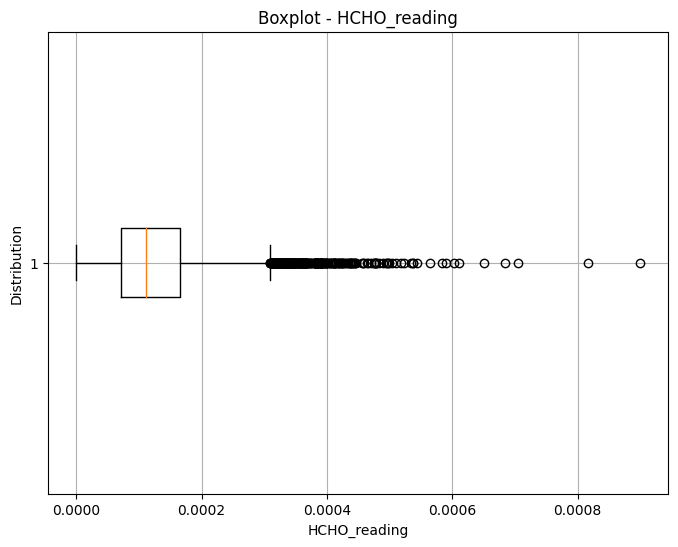

In [27]:
plt.figure(figsize=(8, 6))
plt.boxplot(pd_sl_hcho["HCHO_reading"], vert=False)
plt.title('Boxplot - HCHO_reading')
plt.xlabel('HCHO_reading')
plt.ylabel('Distribution')
plt.grid(True)
plt.show()

summarize the dataset

In [28]:
sl_hcho.groupBy('Location').agg(
    mean('HCHO_reading').alias('mean(HCHO_reading)'),
    median('HCHO_reading'),
    stddev('HCHO_reading')).show()

+-------------------+--------------------+--------------------+--------------------+
|           Location|  mean(HCHO_reading)|median(HCHO_reading)|stddev(HCHO_reading)|
+-------------------+--------------------+--------------------+--------------------+
|       Kandy Proper|1.186940330274530...|1.082787999318966...|7.168878748175666E-5|
|   Deniyaya, Matara|1.101138298190865...| 9.46166031829864E-5|7.859389186304721E-5|
|     Colombo Proper|1.616980807939412...|1.498429396481642...|8.626775682251664E-5|
|Nuwara Eliya Proper|1.033479286983763...| 9.34458382913484E-5| 6.18548434663533E-5|
|  Kurunegala Proper|1.355796710033965...|1.235335184674502...| 7.18851781159679E-5|
| Bibile, Monaragala|1.328318535213345E-4|1.238826189348925E-4|7.551931022549154E-5|
|      Jaffna Proper|1.148576844243088...|1.030505194298694...| 7.09115485891392E-5|
+-------------------+--------------------+--------------------+--------------------+



In [29]:
sl_hcho.agg(
    mean('HCHO_reading').alias('mean(HCHO_reading)'),
    median('HCHO_reading'),
    stddev('HCHO_reading')).show()

+--------------------+--------------------+--------------------+
|  mean(HCHO_reading)|median(HCHO_reading)|stddev(HCHO_reading)|
+--------------------+--------------------+--------------------+
|1.253032973268424...|1.119365329409154E-4|7.636197173728201E-5|
+--------------------+--------------------+--------------------+



scatter plot for mean, median, and standard deviation per city

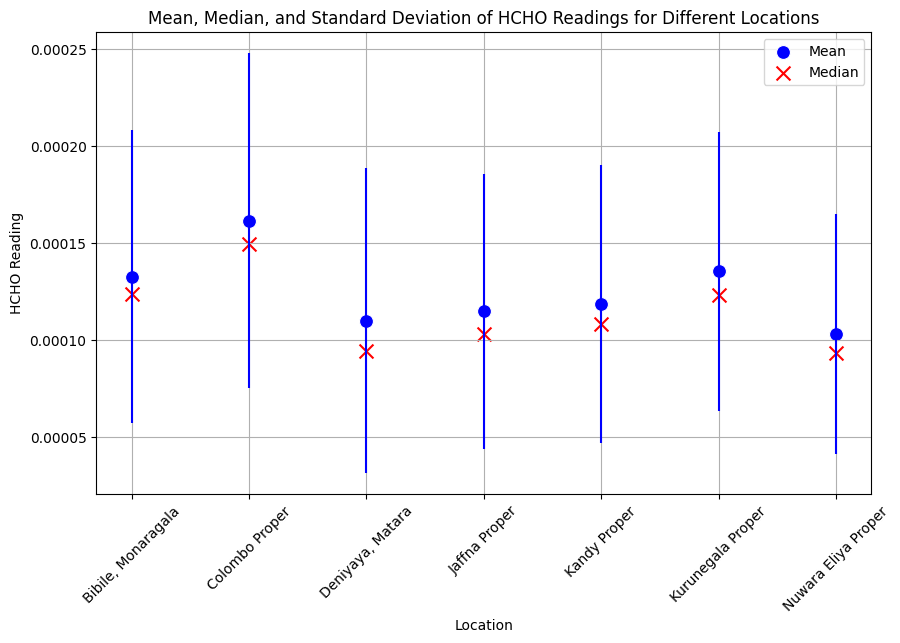

In [30]:
mean_values = pd_sl_hcho.groupby('Location')['HCHO_reading'].mean().reset_index()
median_values = pd_sl_hcho.groupby('Location')['HCHO_reading'].median().reset_index()
std_values = pd_sl_hcho.groupby('Location')['HCHO_reading'].std().reset_index()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Location', y='HCHO_reading', data=mean_values, s=100, color='blue', label='Mean')
plt.errorbar(x=mean_values['Location'], y=mean_values['HCHO_reading'], yerr=std_values['HCHO_reading'], fmt='o', color='blue')
plt.scatter(median_values['Location'], median_values['HCHO_reading'], color='red', s=100, marker='x', label='Median')
plt.title("Mean, Median, and Standard Deviation of HCHO Readings for Different Locations")
plt.xlabel("Location")
plt.ylabel("HCHO Reading")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()


Histogram showcasing HCHO readings for locations

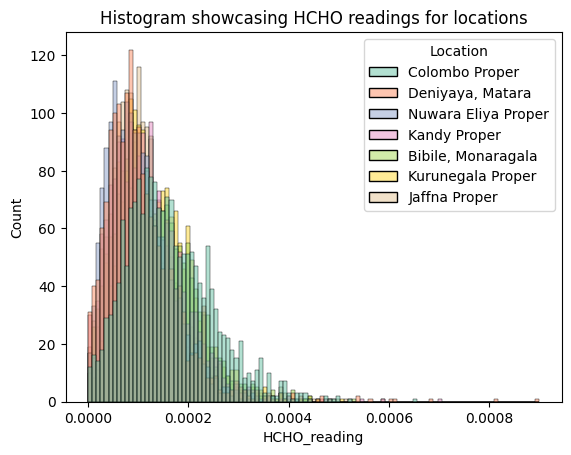

In [31]:
sns.histplot(x='HCHO_reading', palette='Set2', hue='Location', data=pd_sl_hcho)
plt.title("Histogram showcasing HCHO readings for locations")
plt.show()

Histogram reading per city

<ipython-input-32-fabdba9a23a5>:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x='HCHO_reading', palette='Set2', data=pd_sl_hcho[pd_sl_hcho['Location'] == city], ax=ax)
<ipython-input-32-fabdba9a23a5>:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x='HCHO_reading', palette='Set2', data=pd_sl_hcho[pd_sl_hcho['Location'] == city], ax=ax)
<ipython-input-32-fabdba9a23a5>:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x='HCHO_reading', palette='Set2', data=pd_sl_hcho[pd_sl_hcho['Location'] == city], ax=ax)
<ipython-input-32-fabdba9a23a5>:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x='HCHO_reading', palette='Set2', data=pd_sl_hcho[pd_sl_hcho['Location'] == city], ax=ax)
<ipython-input-32-fabdba9a23a5>:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(

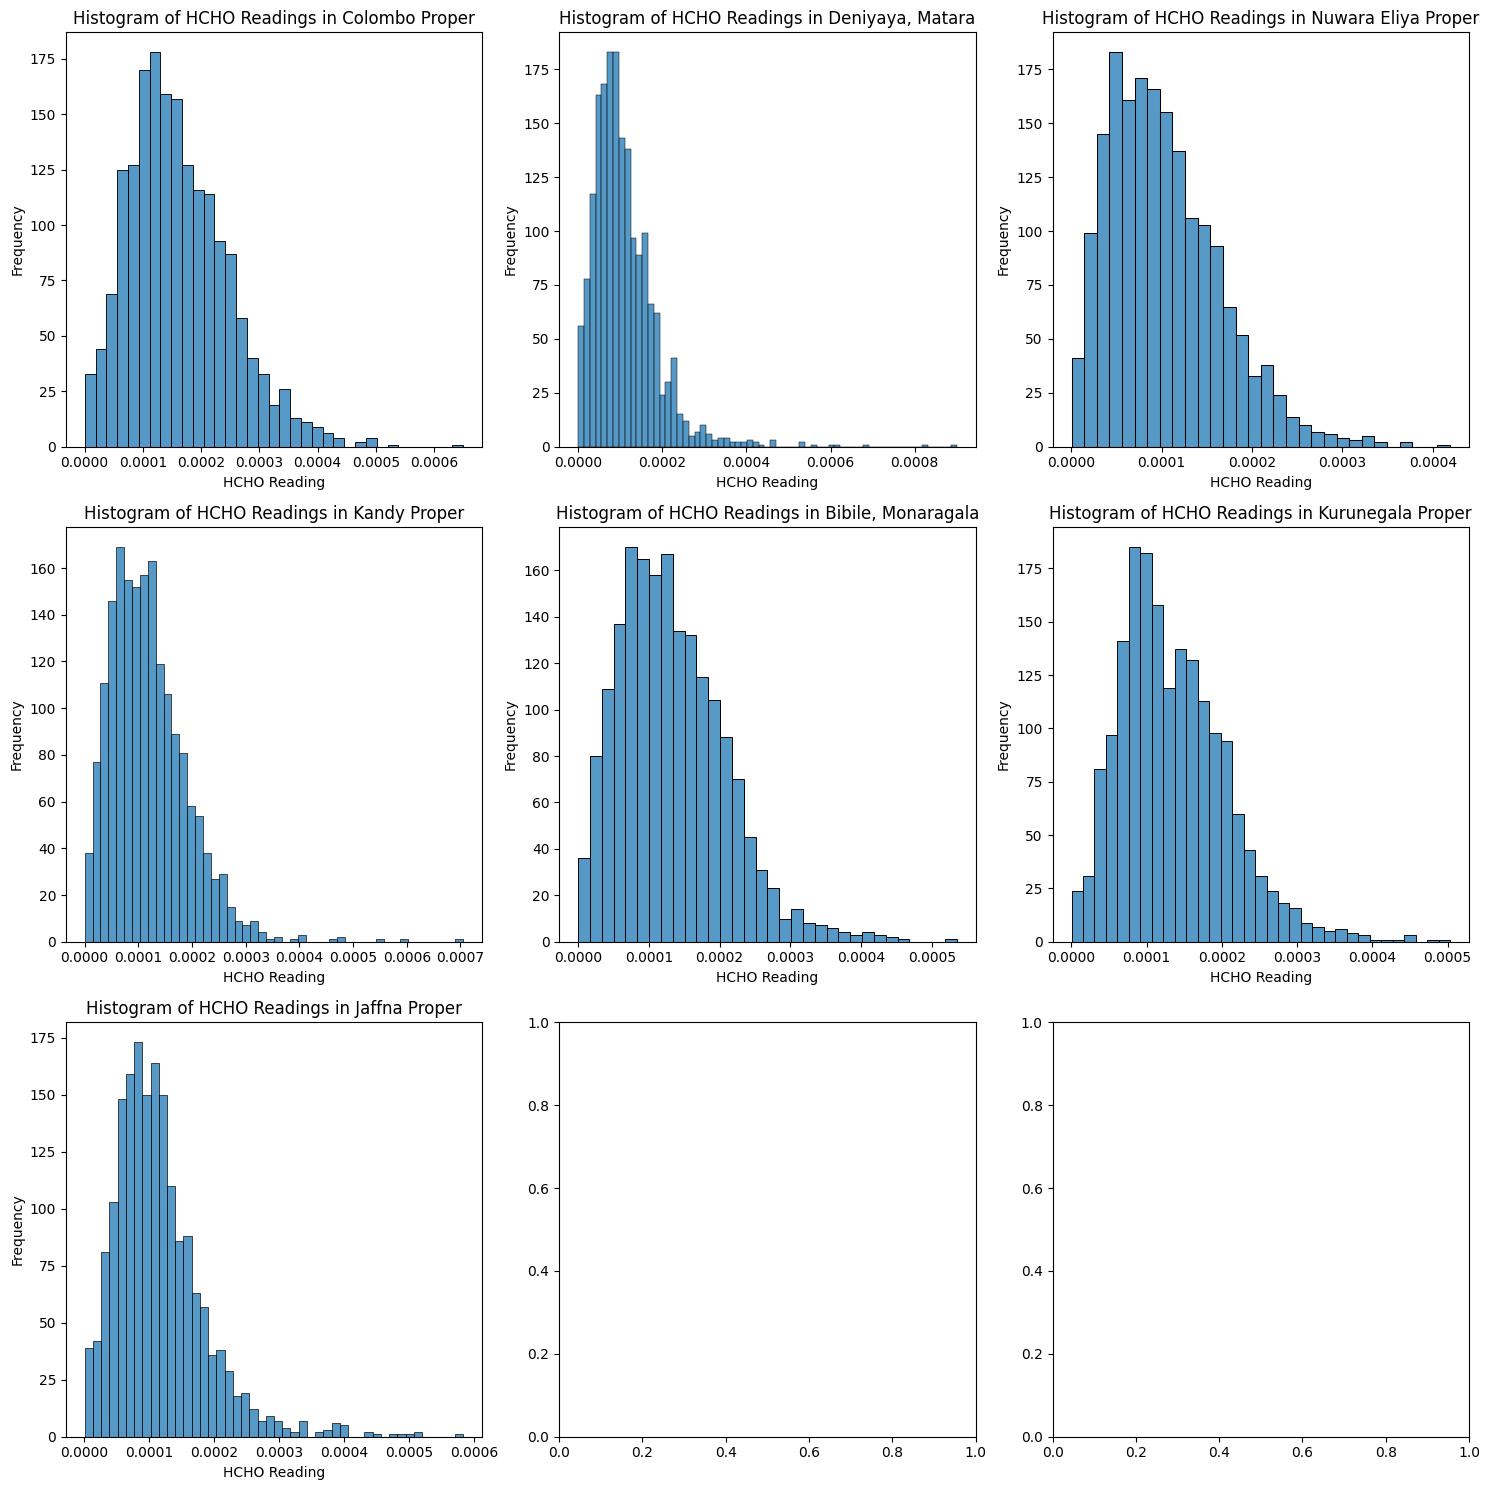

In [32]:
cities = pd_sl_hcho['Location'].unique()
num_cols = 3
num_rows = math.ceil(len(cities) / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))

for i, city in enumerate(cities):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]
    sns.histplot(x='HCHO_reading', palette='Set2', data=pd_sl_hcho[pd_sl_hcho['Location'] == city], ax=ax)
    ax.set_title(f"Histogram of HCHO Readings in {city}")
    ax.set_xlabel("HCHO Reading")
    ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

Boxplots for each city, to see who causes the havoc of outliers

<ipython-input-33-9b5cd5747674>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='HCHO_reading', palette='rocket', y='Location', data=pd_sl_hcho)


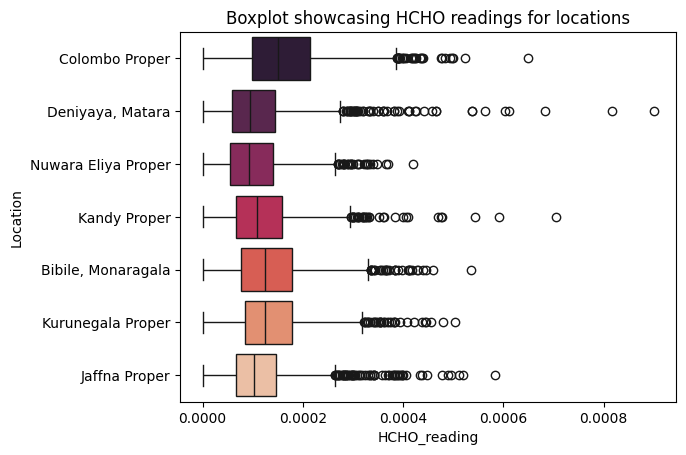

In [33]:
sns.boxplot(x='HCHO_reading', palette='rocket', y='Location', data=pd_sl_hcho)
plt.title("Boxplot showcasing HCHO readings for locations")
plt.show()

# Spatio Temporal Analysis

In [34]:
grouped = pd_sl_hcho.groupby("Location")

plot time series for each location from 2019 to 2023

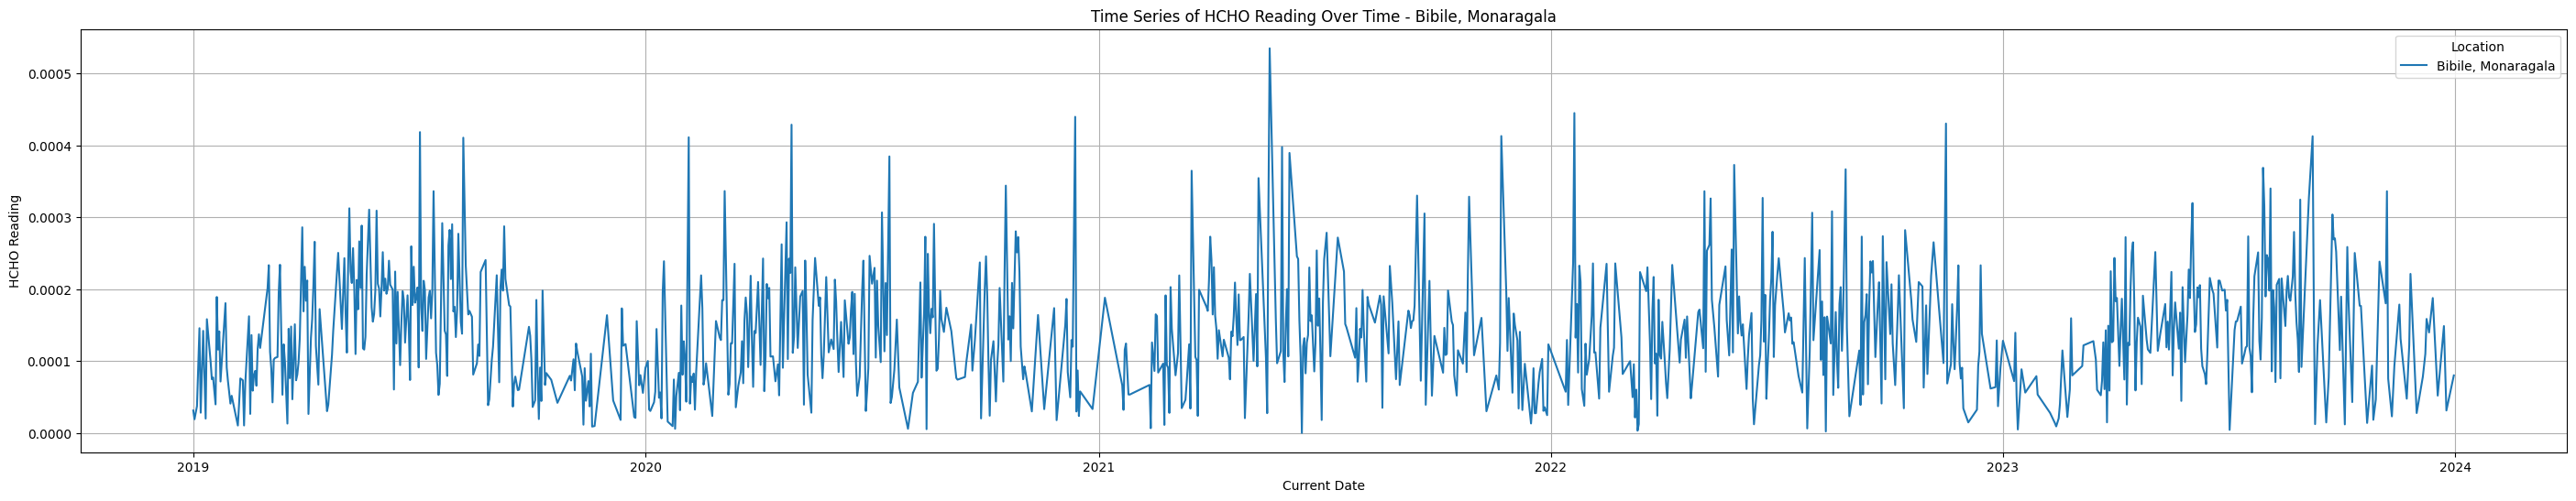

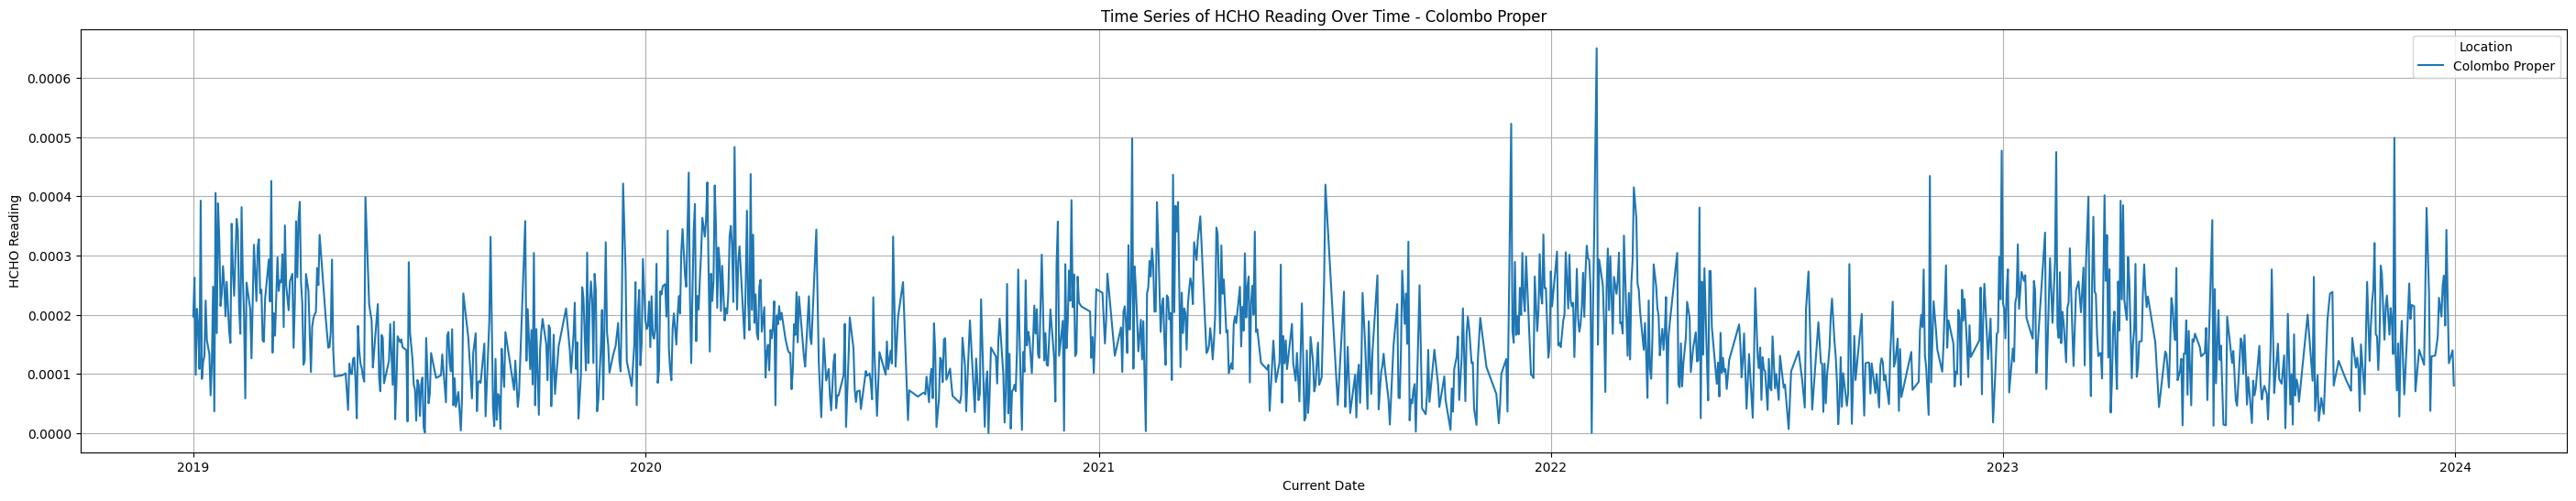

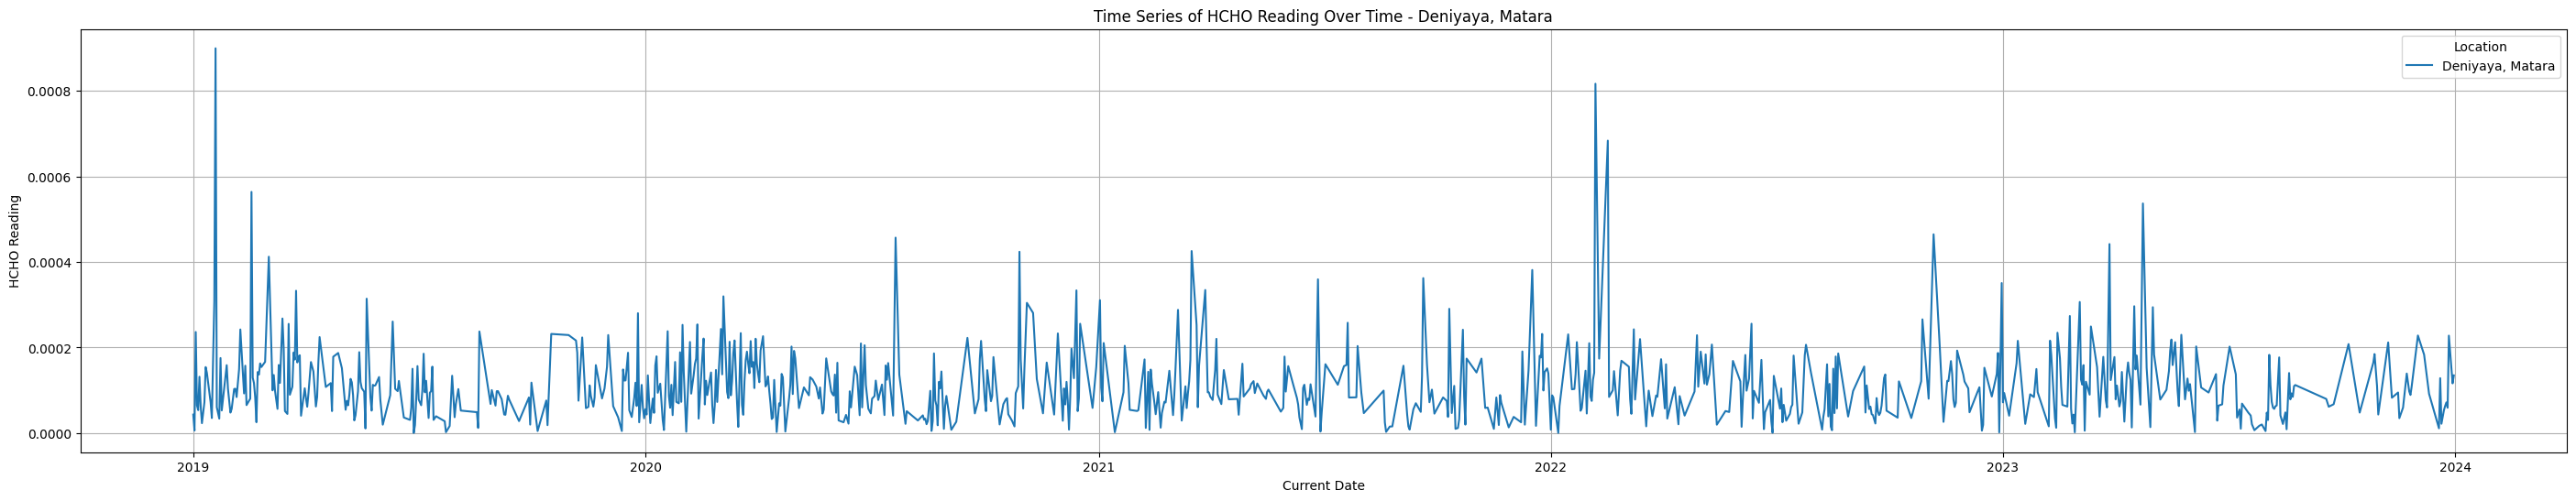

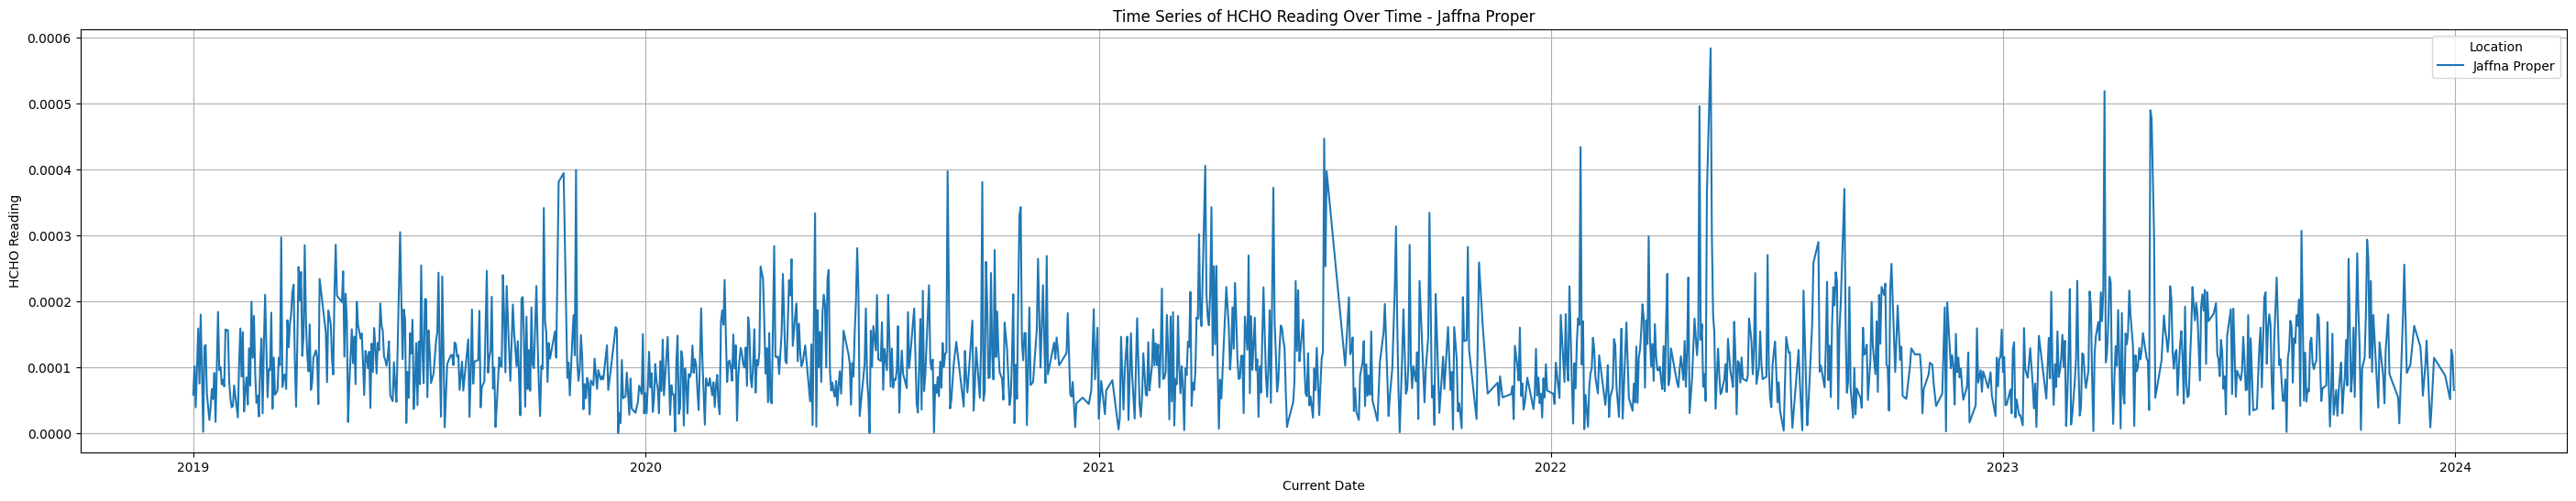

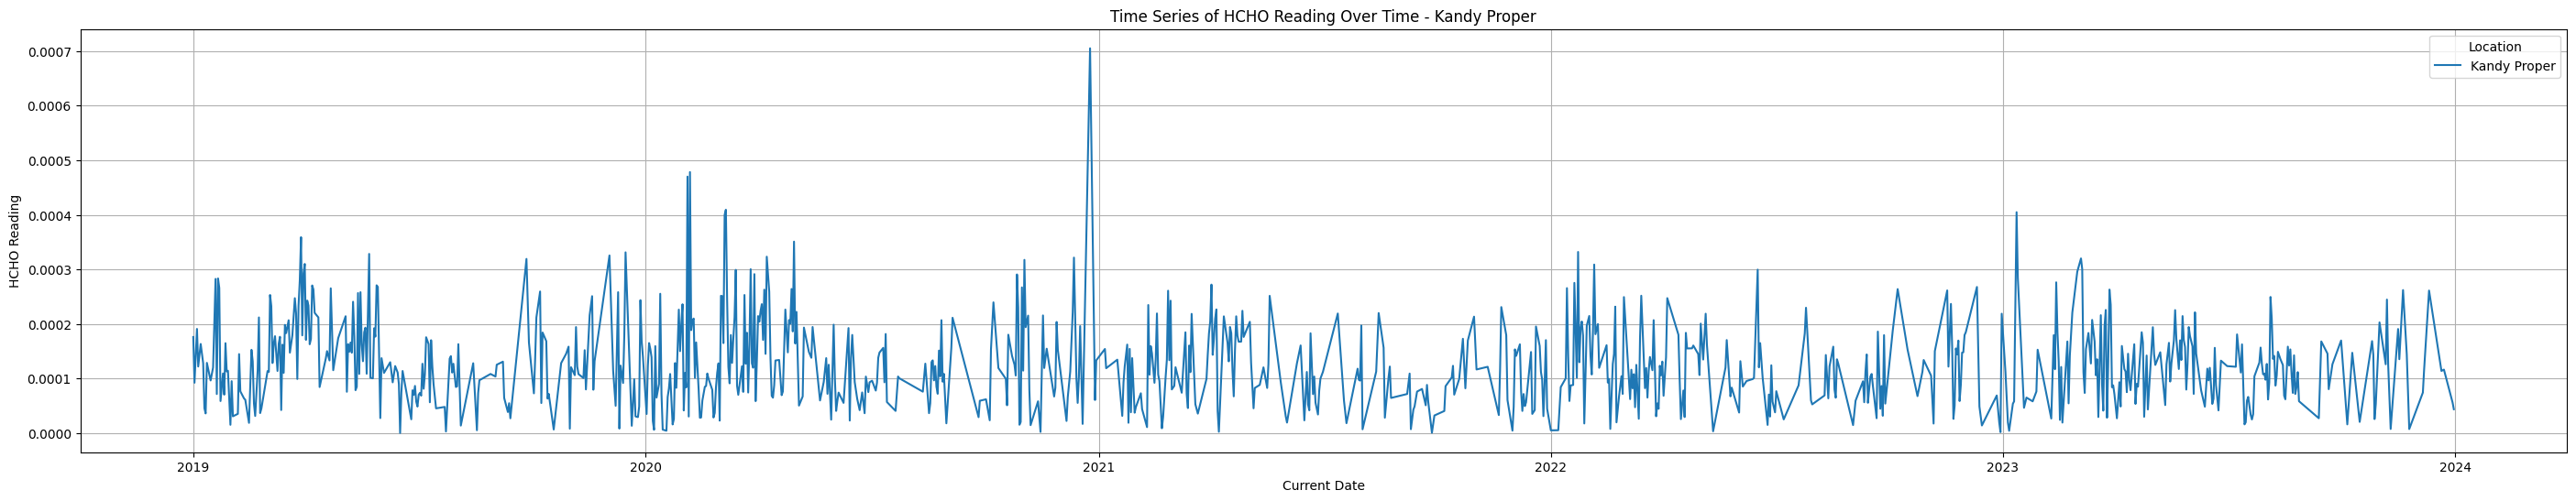

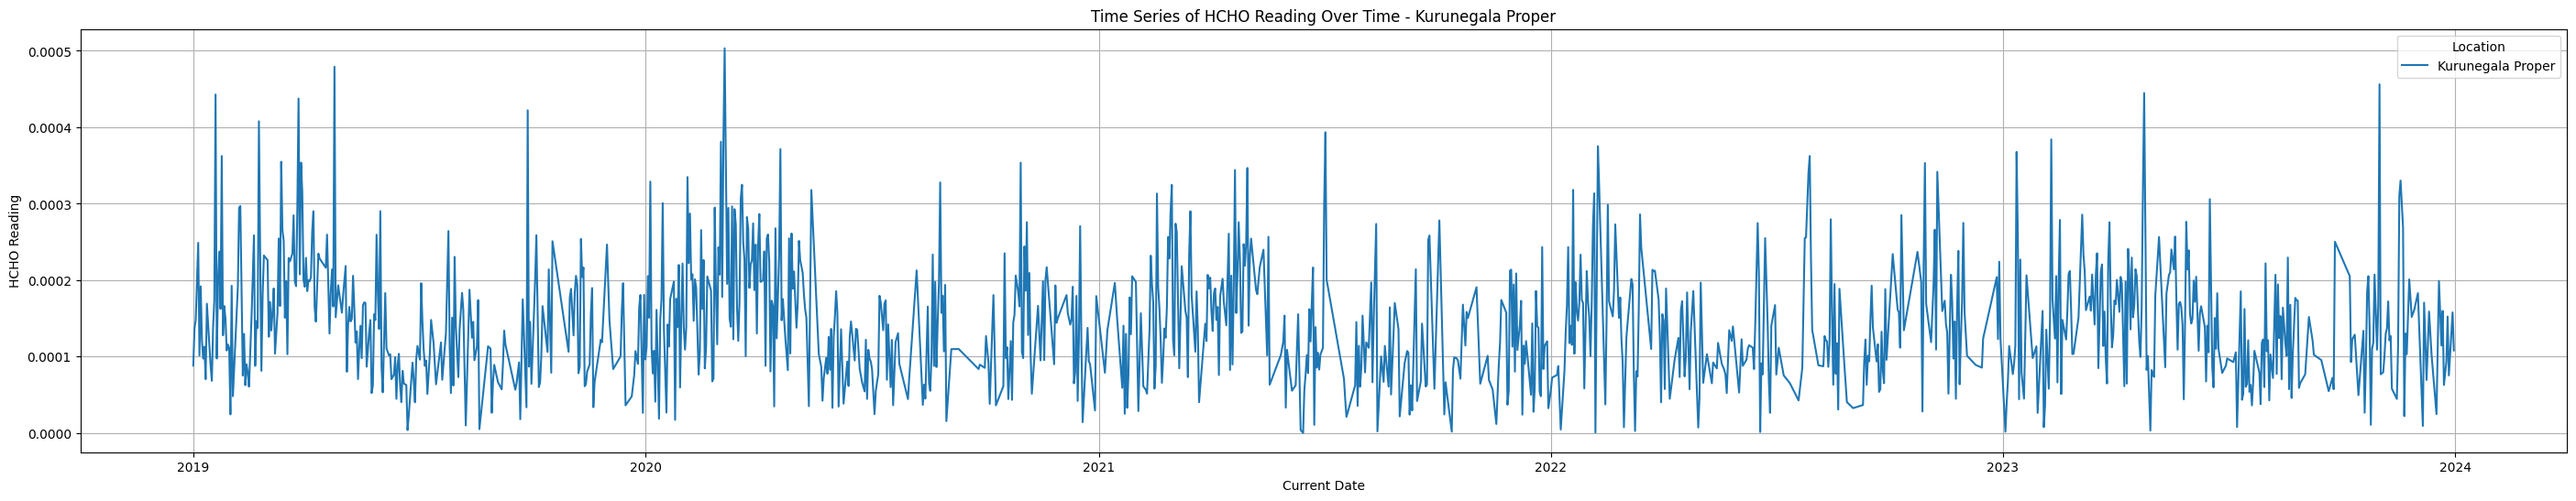

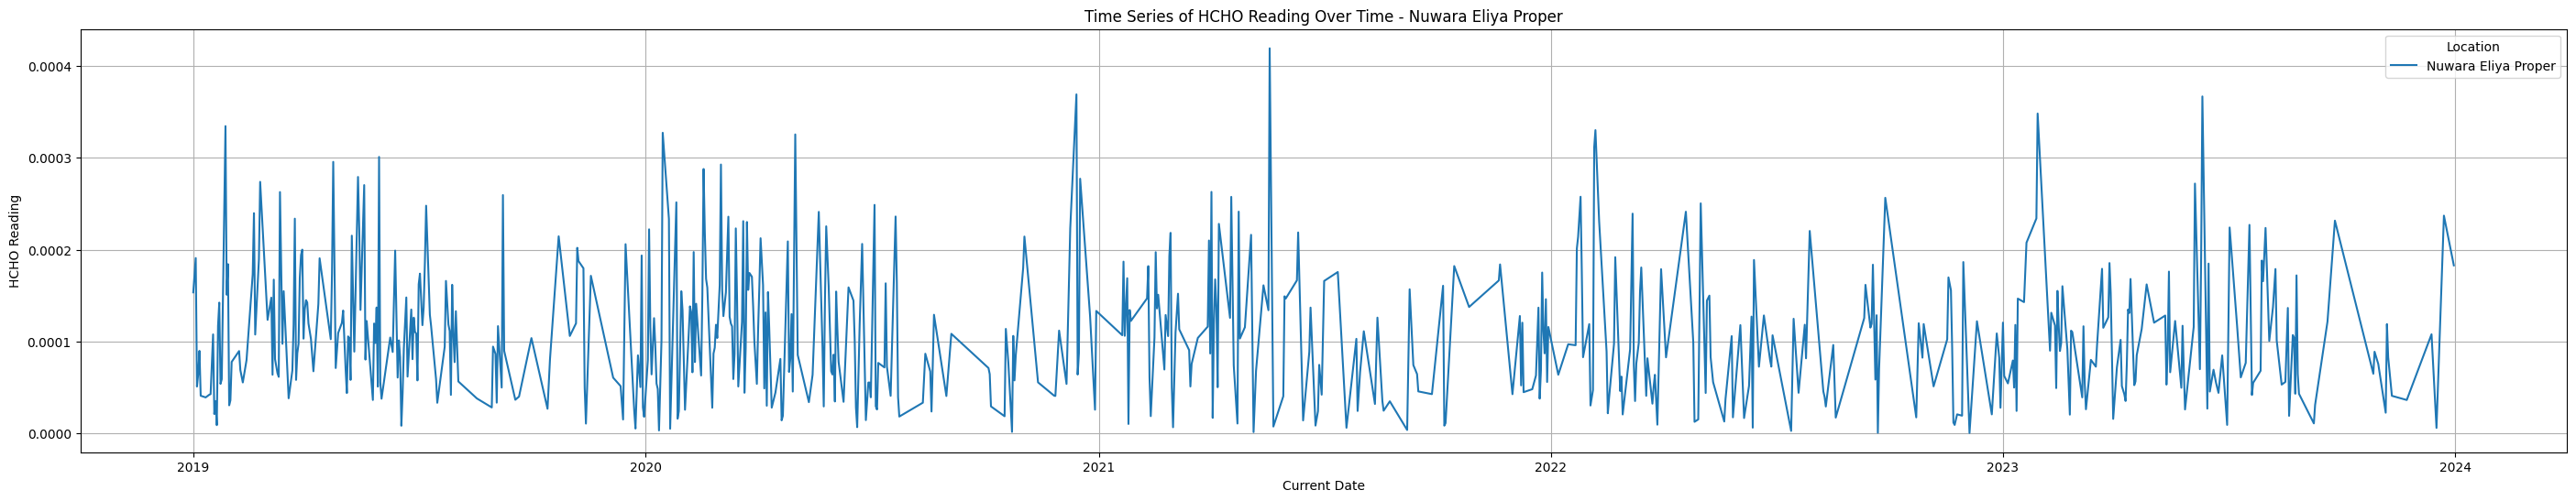

In [35]:
for location, group_data in grouped:
  plt.figure(figsize=(35, 6))
  plt.plot(group_data['Current_date'], group_data['HCHO_reading'], label=location)
  plt.title(f'Time Series of HCHO Reading Over Time - {location}')
  plt.xlabel('Current Date')
  plt.ylabel('HCHO Reading')
  plt.legend(title='Location')
  plt.grid(True)
  plt.show()

In [36]:
import datetime

Lockdown period dilemma

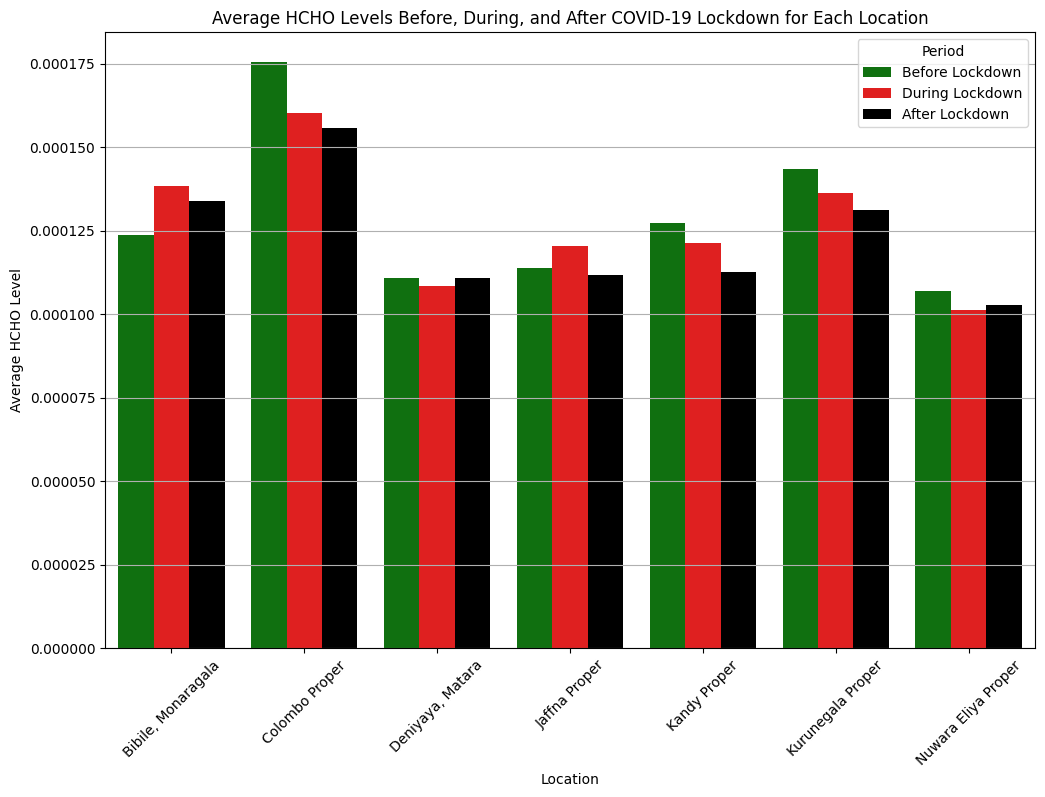

In [40]:
before_lockdown = pd_sl_hcho[(pd_sl_hcho['Current_date'] <= datetime.date(2020, 3, 3))]
lockdown = pd_sl_hcho[(pd_sl_hcho['Current_date'] >= datetime.date(2020, 3, 3)) & (pd_sl_hcho['Current_date'] <= datetime.date(2021, 9, 6))]
after_lockdown = pd_sl_hcho[(pd_sl_hcho['Current_date'] >= datetime.date(2021, 9, 6))]

# Calculate average HCHO levels before, during and after the lockdown period for each city
before_lockdown_avg = before_lockdown.groupby('Location')['HCHO_reading'].mean()
lockdown_avg = lockdown.groupby('Location')['HCHO_reading'].mean()
after_lockdown_avg = after_lockdown.groupby('Location')['HCHO_reading'].mean()

# Combine the average HCHO levels for each period into a single DataFrame
data = pd.DataFrame({
    'Location': before_lockdown_avg.index,
    'Before Lockdown': before_lockdown_avg.values,
    'During Lockdown': lockdown_avg.values,
    'After Lockdown': after_lockdown_avg.values
})

# Melt the DataFrame so that the average HCHO levels for each period are in the same column
melted_data = pd.melt(data, id_vars='Location', value_vars=['Before Lockdown', 'During Lockdown', 'After Lockdown'],
                      var_name='Period', value_name='Average HCHO Level')

# Plot the combined data using sns.barplot
plt.figure(figsize=(12, 8))
sns.barplot(x='Location', y='Average HCHO Level', hue='Period', data=melted_data,
            palette={'Before Lockdown': 'green', 'During Lockdown': 'red', 'After Lockdown': 'black'})

plt.title('Average HCHO Levels Before, During, and After COVID-19 Lockdown for Each Location')
plt.xlabel('Location')
plt.ylabel('Average HCHO Level')
plt.xticks(rotation=45)
plt.legend(title='Period')
plt.grid(axis='y')
plt.show()

Considering other factors

In [41]:
stats = spark.read.csv("/content/Coordinates.csv", header = True, inferSchema=True)

analyze the data a bit

In [42]:
stats.printSchema()

root
 |-- STATION: string (nullable = true)
 |-- NAME: string (nullable = true)
 |-- LATITUDE: double (nullable = true)
 |-- LONGITUDE: double (nullable = true)
 |-- ELEVATION: double (nullable = true)
 |-- DATE: date (nullable = true)
 |-- PRCP: double (nullable = true)
 |-- TAVG: integer (nullable = true)
 |-- TMAX: integer (nullable = true)
 |-- TMIN: integer (nullable = true)



In [43]:
stats.show()

+-----------+--------------+--------+---------+---------+----------+----+----+----+----+
|    STATION|          NAME|LATITUDE|LONGITUDE|ELEVATION|      DATE|PRCP|TAVG|TMAX|TMIN|
+-----------+--------------+--------+---------+---------+----------+----+----+----+----+
|CEM00043441|KURUNEGALA, CE|   7.467|   80.367|    116.0|2019-01-02| 0.0|  78|NULL|  72|
|CEM00043441|KURUNEGALA, CE|   7.467|   80.367|    116.0|2019-01-03| 0.0|  81|  87|  71|
|CEM00043441|KURUNEGALA, CE|   7.467|   80.367|    116.0|2019-01-04| 0.0|  83|  88|  69|
|CEM00043441|KURUNEGALA, CE|   7.467|   80.367|    116.0|2019-01-05| 0.0|  84|  90|  65|
|CEM00043441|KURUNEGALA, CE|   7.467|   80.367|    116.0|2019-01-06| 0.0|  82|  88|  71|
|CEM00043441|KURUNEGALA, CE|   7.467|   80.367|    116.0|2019-01-07| 0.0|  80|  89|  68|
|CEM00043441|KURUNEGALA, CE|   7.467|   80.367|    116.0|2019-01-08| 0.0|  82|  90|  71|
|CEM00043441|KURUNEGALA, CE|   7.467|   80.367|    116.0|2019-01-09| 0.0|  83|  89|  71|
|CEM00043441|KURUNEGA

In [44]:
stats.count()

8745

In [45]:
stats.groupBy("NAME").count().show()

+----------------+-----+
|            NAME|count|
+----------------+-----+
|  KURUNEGALA, CE| 1704|
|    PUTTALAM, CE| 1755|
|     COLOMBO, CE| 1765|
|NUWARA ELIYA, CE| 1761|
|   CHINA BAY, CE| 1760|
+----------------+-----+



In [50]:
from pyspark.sql import functions as F

# Assuming 'stats' is your DataFrame
null_counts = stats.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in stats.columns])

# Print the results
null_counts.show()

+-------+----+--------+---------+---------+----+----+----+----+----+
|STATION|NAME|LATITUDE|LONGITUDE|ELEVATION|DATE|PRCP|TAVG|TMAX|TMIN|
+-------+----+--------+---------+---------+----+----+----+----+----+
|      0|   0|       0|        0|        0|   0|  37|   0| 959|1646|
+-------+----+--------+---------+---------+----+----+----+----+----+



spark to pandas

In [51]:
statistics = stats.toPandas()

In [52]:
statistic_fix = statistics.interpolate(method="linear")

In [53]:
statistic_fix.isnull().sum()

STATION      0
NAME         0
LATITUDE     0
LONGITUDE    0
ELEVATION    0
DATE         0
PRCP         0
TAVG         0
TMAX         1
TMIN         0
dtype: int64

In [54]:
statistic_fix.drop(columns=['TMAX', 'TMIN'], inplace=True)

In [55]:
statistic_fix.isnull().sum()

STATION      0
NAME         0
LATITUDE     0
LONGITUDE    0
ELEVATION    0
DATE         0
PRCP         0
TAVG         0
dtype: int64

Change 'Name' of rows where 'Name' is 'KURUNEGALA, CE' to 'Kurunegala proper' and where 'Name' is 'COLOMBO, CE' to 'colombo proper'

In [57]:
stats = spark.createDataFrame(pd.DataFrame(statistic_fix))

In [58]:
stats = stats.withColumn(
    'Name',
    F.when(F.col('Name') == 'KURUNEGALA, CE', 'Kurunegala Proper')
    .when(F.col('Name') == 'COLOMBO, CE', 'Colombo Proper')
    .when(F.col('Name') == 'NUWARA ELIYA, CE', 'Nuwara Eliya Proper')
    .otherwise(F.col('Name'))
)

remove unwanted cities

In [59]:
stats = stats.filter(~(F.col('Name') == 'PUTTALAM, CE') & ~(F.col('Name') == 'CHINA BAY, CE'))

In [60]:
stats.groupBy('Name').count().show()

+-------------------+-----+
|               Name|count|
+-------------------+-----+
|  Kurunegala Proper| 1704|
|     Colombo Proper| 1765|
|Nuwara Eliya Proper| 1761|
+-------------------+-----+



In [61]:
stats.show()

+-----------+-----------------+--------+---------+---------+----------+----+----+
|    STATION|             Name|LATITUDE|LONGITUDE|ELEVATION|      DATE|PRCP|TAVG|
+-----------+-----------------+--------+---------+---------+----------+----+----+
|CEM00043441|Kurunegala Proper|   7.467|   80.367|    116.0|2019-01-02| 0.0|  78|
|CEM00043441|Kurunegala Proper|   7.467|   80.367|    116.0|2019-01-03| 0.0|  81|
|CEM00043441|Kurunegala Proper|   7.467|   80.367|    116.0|2019-01-04| 0.0|  83|
|CEM00043441|Kurunegala Proper|   7.467|   80.367|    116.0|2019-01-05| 0.0|  84|
|CEM00043441|Kurunegala Proper|   7.467|   80.367|    116.0|2019-01-06| 0.0|  82|
|CEM00043441|Kurunegala Proper|   7.467|   80.367|    116.0|2019-01-07| 0.0|  80|
|CEM00043441|Kurunegala Proper|   7.467|   80.367|    116.0|2019-01-08| 0.0|  82|
|CEM00043441|Kurunegala Proper|   7.467|   80.367|    116.0|2019-01-09| 0.0|  83|
|CEM00043441|Kurunegala Proper|   7.467|   80.367|    116.0|2019-01-10| 0.0|  81|
|CEM00043441|Kur

merge the data sets UwU

In [62]:
merged_data = sl_hcho.join(stats, (sl_hcho['Location'] == stats['Name']) & (sl_hcho['Current_date'] == stats['DATE']), 'inner')
stat_with_hcho = merged_data.select(stats['*'], sl_hcho['HCHO_reading'])
stat_with_hcho.show()

+-----------+-----------------+--------+---------+---------+----------+----+----+--------------------+
|    STATION|             Name|LATITUDE|LONGITUDE|ELEVATION|      DATE|PRCP|TAVG|        HCHO_reading|
+-----------+-----------------+--------+---------+---------+----------+----+----+--------------------+
|CEM00043441|Kurunegala Proper|   7.467|   80.367|    116.0|2020-12-01| 0.0|  79|1.589783747749801...|
|CEM00043441|Kurunegala Proper|   7.467|   80.367|    116.0|2021-01-30| 0.0|  81|2.001557642128359E-4|
|CEM00043441|Kurunegala Proper|   7.467|   80.367|    116.0|2022-07-17| 0.0|  83|5.233535480542129...|
|CEM00043441|Kurunegala Proper|   7.467|   80.367|    116.0|2023-02-24| 0.0|  82|2.119280425394987...|
|CEM00043466|   Colombo Proper|     6.9|   79.867|      7.0|2019-02-21| 0.0|  82|2.230429464187653E-4|
|CEM00043466|   Colombo Proper|     6.9|   79.867|      7.0|2019-09-15|1.07|  80|1.008502184791516...|
|CEM00043466|   Colombo Proper|     6.9|   79.867|      7.0|2019-10-21| 1

In [63]:
stat_with_hcho.count()

5230

check for null values just in case

In [64]:
null101 = stat_with_hcho.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in stat_with_hcho.columns])

# Print the results
null101.show()

+-------+----+--------+---------+---------+----+----+----+------------+
|STATION|Name|LATITUDE|LONGITUDE|ELEVATION|DATE|PRCP|TAVG|HCHO_reading|
+-------+----+--------+---------+---------+----+----+----+------------+
|      0|   0|       0|        0|        0|   0|   0|   0|           0|
+-------+----+--------+---------+---------+----+----+----+------------+



Finally! now let's convert this into Pandas, again

In [65]:
statistics_hcho = stat_with_hcho.toPandas()
statistics_hcho.head()

,STATION,Name,LATITUDE,LONGITUDE,ELEVATION,DATE,PRCP,TAVG,HCHO_reading
0,CEM00043441,Kurunegala Proper,7.467,80.367,116.0,2020-12-01,0.0,79,0.000159
1,CEM00043441,Kurunegala Proper,7.467,80.367,116.0,2021-01-30,0.0,81,0.000200
2,CEM00043441,Kurunegala Proper,7.467,80.367,116.0,2022-07-17,0.0,83,0.000052
3,CEM00043441,Kurunegala Proper,7.467,80.367,116.0,2023-02-24,0.0,82,0.000212
4,CEM00043466,Colombo Proper,6.900,79.867,7.0,2019-02-21,0.0,82,0.000223


dropping station coz it's annoying

In [66]:
statistics_hcho.drop('STATION', axis=1, inplace=True)
statistics_hcho.head()

,Name,LATITUDE,LONGITUDE,ELEVATION,DATE,PRCP,TAVG,HCHO_reading
0,Kurunegala Proper,7.467,80.367,116.0,2020-12-01,0.0,79,0.000159
1,Kurunegala Proper,7.467,80.367,116.0,2021-01-30,0.0,81,0.000200
2,Kurunegala Proper,7.467,80.367,116.0,2022-07-17,0.0,83,0.000052
3,Kurunegala Proper,7.467,80.367,116.0,2023-02-24,0.0,82,0.000212
4,Colombo Proper,6.900,79.867,7.0,2019-02-21,0.0,82,0.000223


can we change the column names? like why are you yelling

In [70]:
statistics_hcho = statistics_hcho.rename(columns={'Name': 'City', 'LATITUDE': 'Latitude', 'LONGITUDE': 'Longitudes', 'ELEVATION': 'Elevation','DATE': 'Date','PRCP': 'Precipitation','TAVG': 'Temperature'})


we can see the data types now

In [71]:
statistics_hcho.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5230 entries, 0 to 5229
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   City           5230 non-null   object 
 1   Latitude       5230 non-null   float64
 2   Longitudes     5230 non-null   float64
 3   Elevation      5230 non-null   float64
 4   Date           5230 non-null   object 
 5   Precipitation  5230 non-null   float64
 6   Temperature    5230 non-null   int64  
 7   HCHO_reading   5230 non-null   float64
dtypes: float64(5), int64(1), object(2)
memory usage: 327.0+ KB


Now we gotta plot the heatmap, so filter out numerical columns for that first

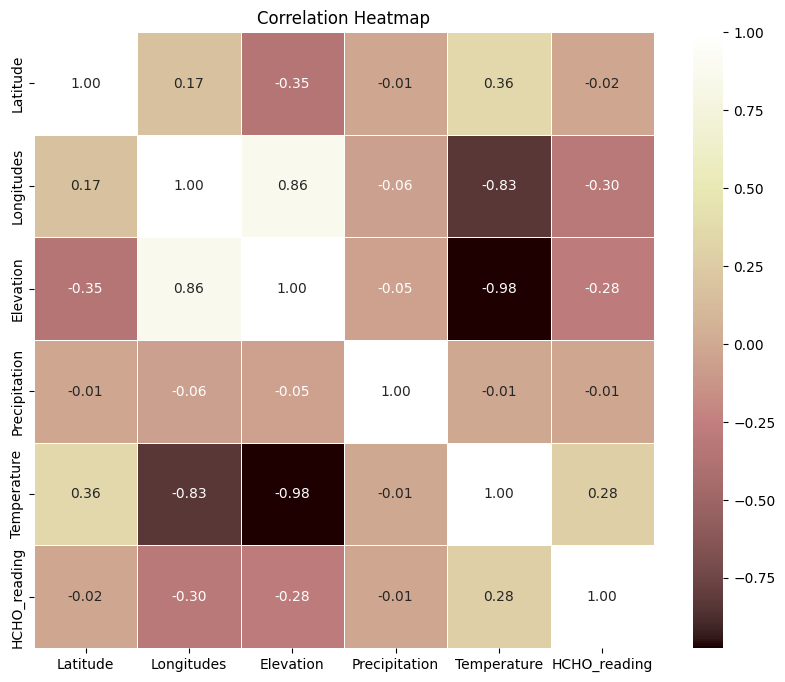

In [77]:
numerix = statistics_hcho.select_dtypes(include=['int64', 'float64']).columns
corr_matrix = statistics_hcho[numerix].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='pink', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

<Figure size 1000x800 with 0 Axes>

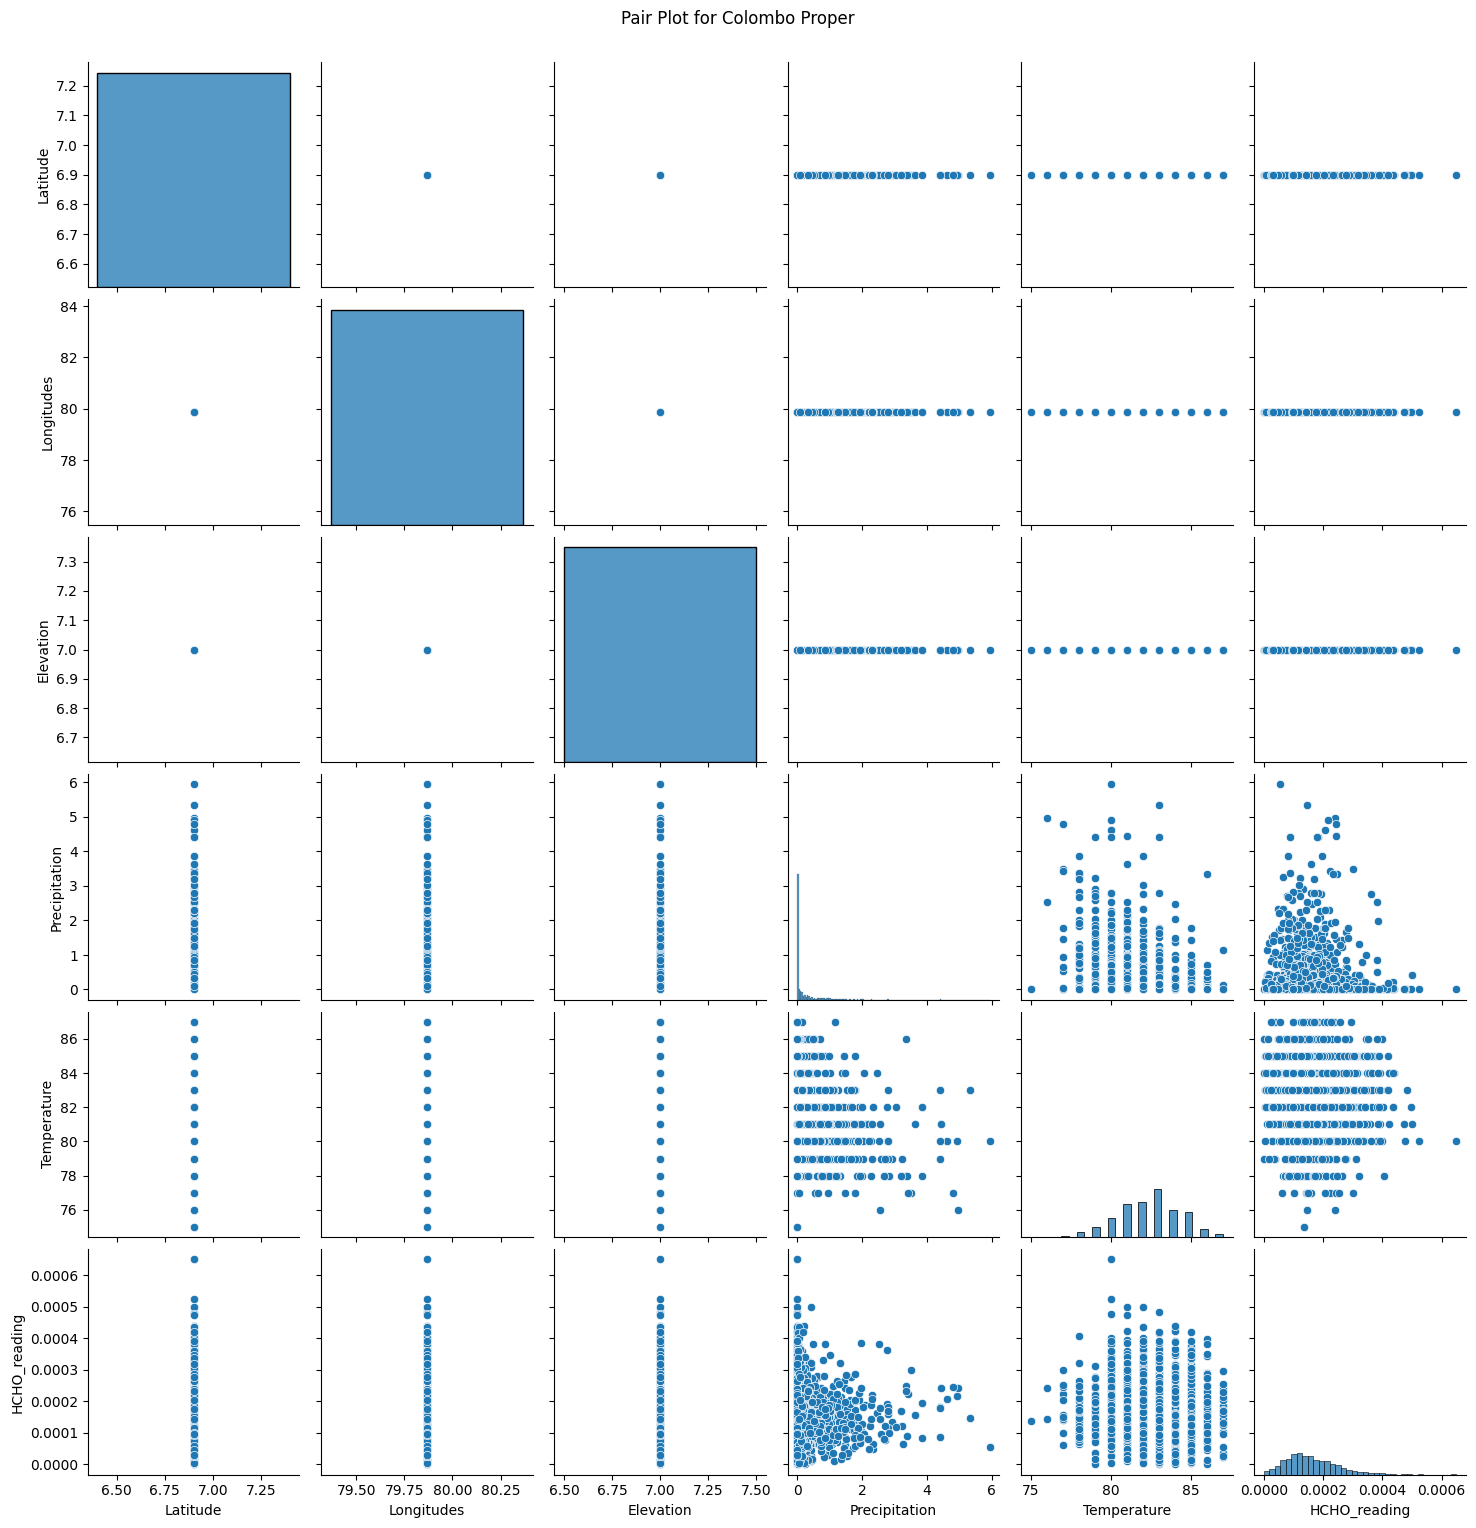

<Figure size 1000x800 with 0 Axes>

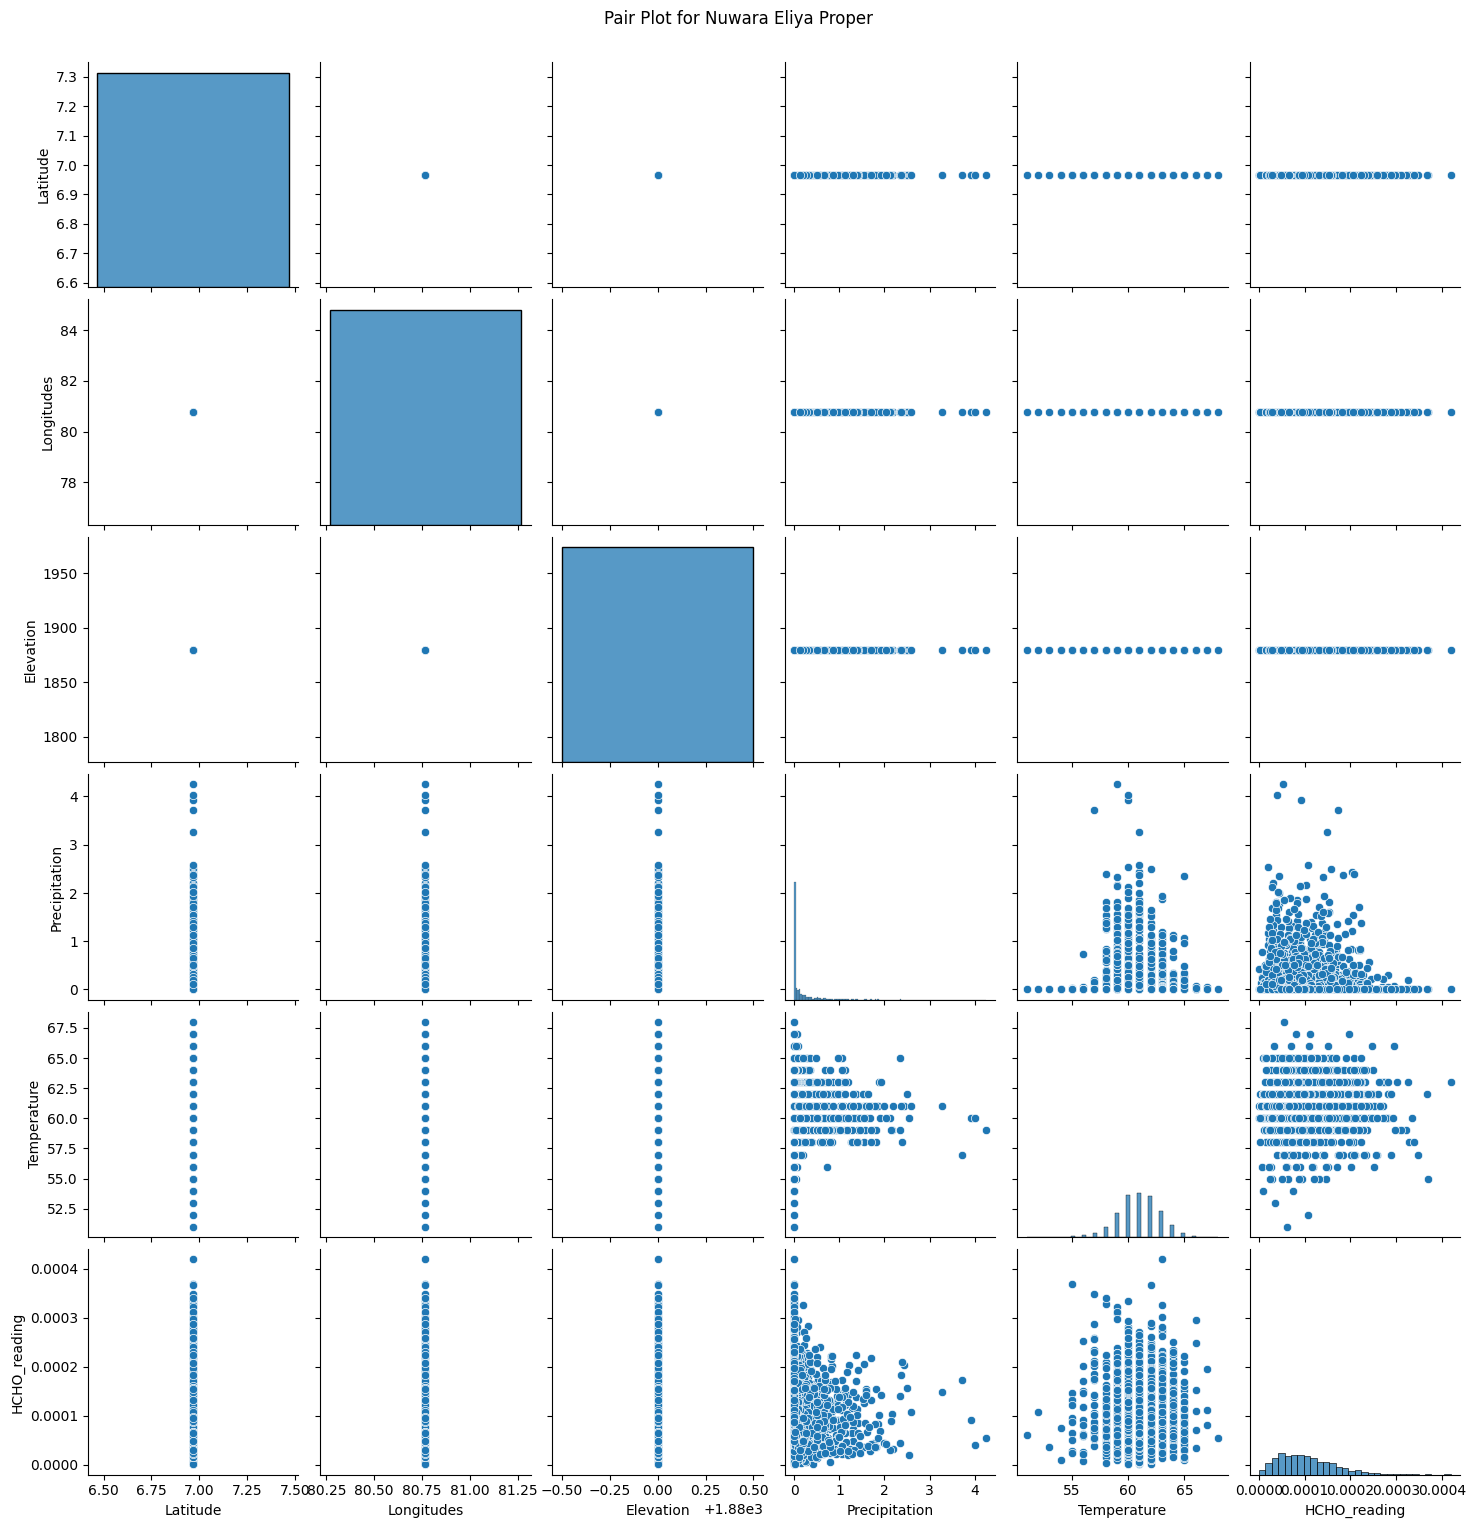

<Figure size 1000x800 with 0 Axes>

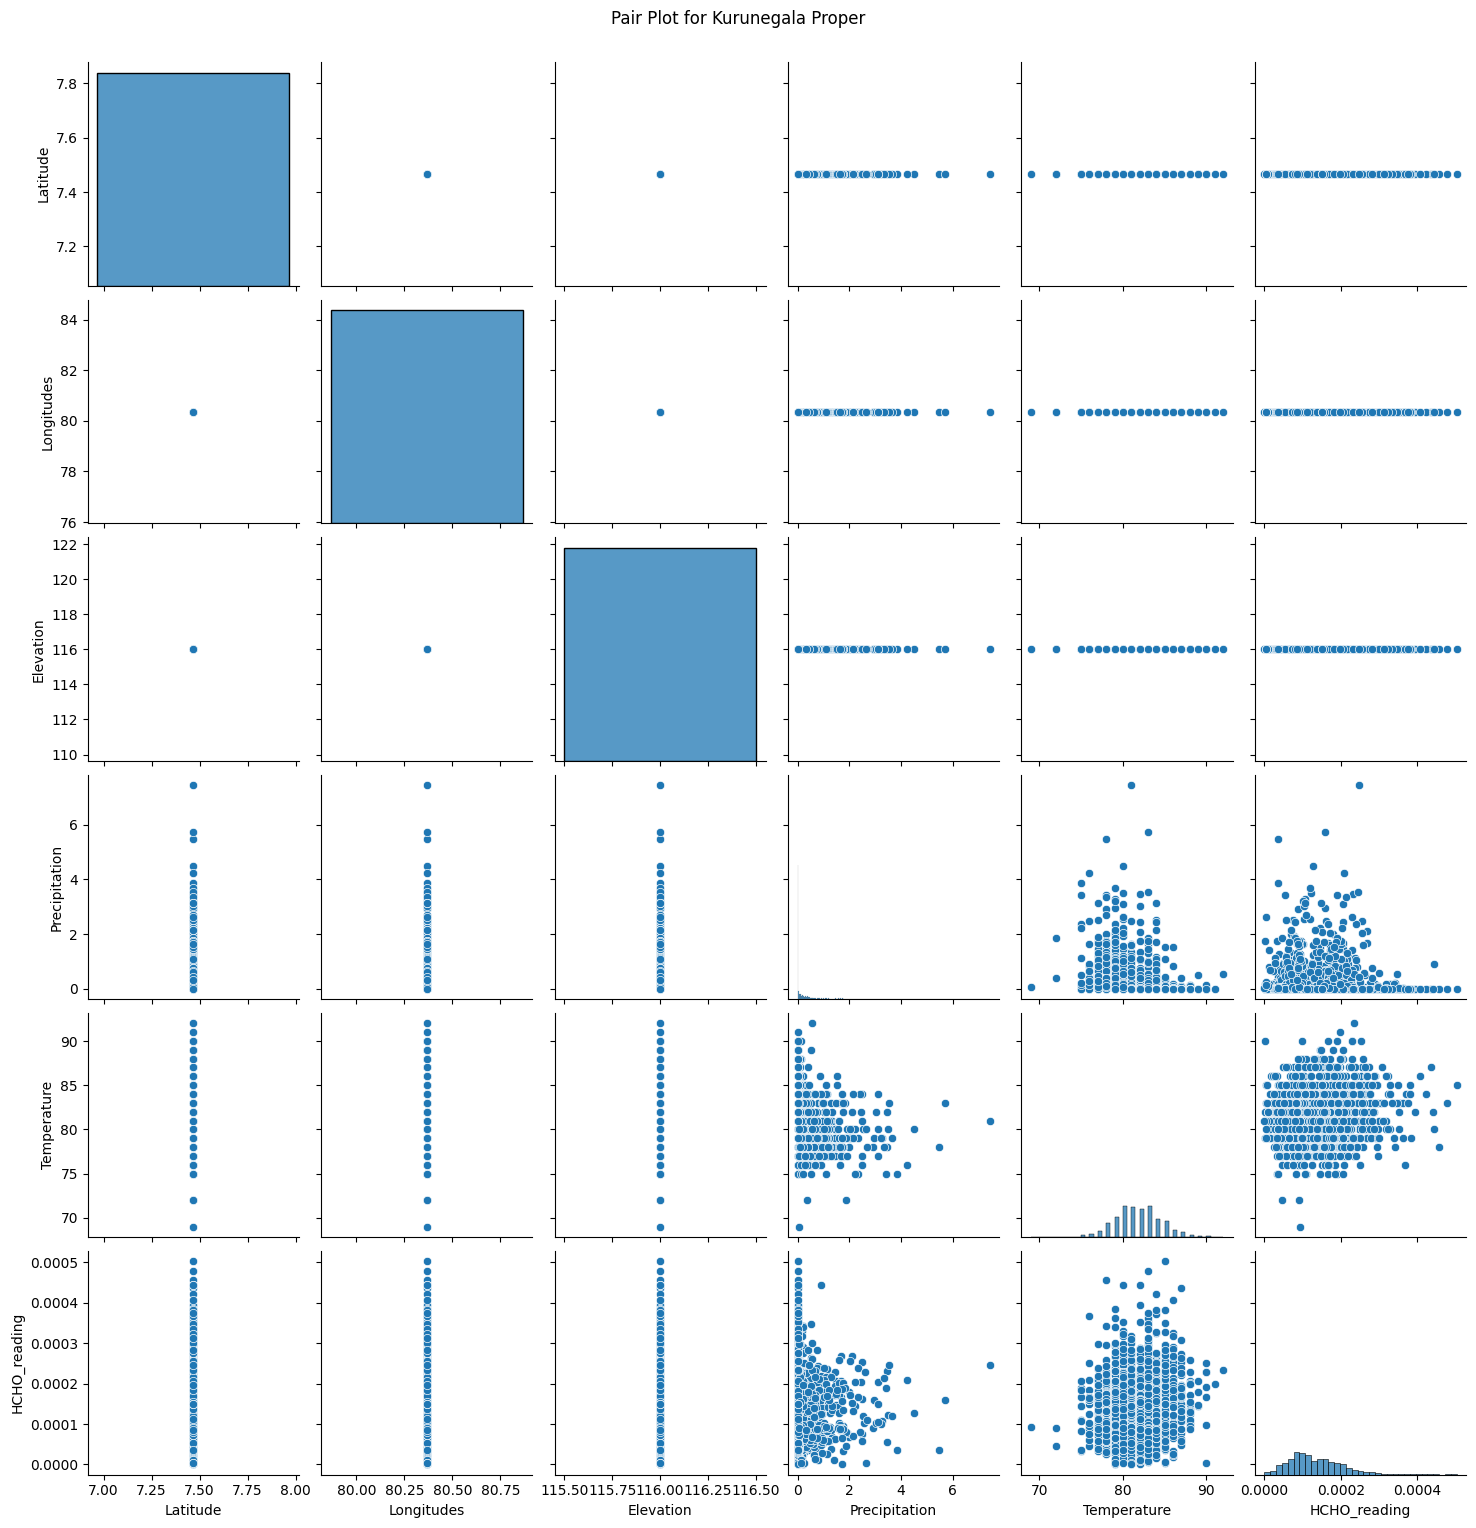

In [78]:
location_names = ['Colombo Proper', 'Nuwara Eliya Proper', 'Kurunegala Proper']
for location in location_names:
    location_data = statistics_hcho[statistics_hcho['City'] == location]
    numerical_columns = location_data.select_dtypes(include=['int64', 'float64']).columns
    plt.figure(figsize=(10, 8))
    sns.pairplot(location_data[numerical_columns])
    plt.suptitle(f'Pair Plot for {location}', y=1.02)
    plt.show()


In [79]:
statistics_hcho.to_csv("Overall_stats.csv", index=False)